In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
# pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field
from skimage.transform import resize

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate

In [2]:
b_cube = np.load('/mnt/userdata/jeon_mg/low_lou_test/test/case1.npz')['b'].astype(np.float32)

In [3]:
b_cube.shape

(64, 64, 64, 3)

In [4]:
b_bottom = b_cube[:, :, 0, :]
b_bottom.shape

(64, 64, 3)

In [5]:
meta_path = Path("/userhome/jeon_mg/workspace/base/uno_pi_cc_hnorm_unit_aug_ccc_square_energy_lowlou")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
model_input = b_bottom

In [7]:
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

torch.Size([1, 1, 64, 64, 3])

In [8]:
model_output = model(model_input)

In [9]:
model_output.shape

torch.Size([1, 64, 64, 64, 3])

In [10]:
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [11]:
b.shape

(64, 64, 64, 3)

In [12]:
evaluate(b, b_cube)

C_vec     : 0.9982
C_cs      : 0.9726
E_n'      : 0.8985
E_m'      : 0.8099
eps       : 1.0066
CW_sin    : 0.3030
L_f       : 0.0882
L_d       : 0.0441
l2_err    : 0.0608


{'C_vec': 0.9981617095600194,
 'C_cs': 0.9725884451650051,
 "E_n'": 0.8984830944654774,
 "E_m'": 0.8098592003590241,
 'eps': 1.006618176095644,
 'CW_sin': 0.3029596631346016,
 'L_f': 0.08824994878352362,
 'L_d': 0.04414618600683767,
 'l2_err': 0.06082521467311937}

In [12]:
evaluate(b, b_cube)

C_vec     : 0.9950
C_cs      : 0.9248
E_n'      : 0.8332
E_m'      : 0.6962
eps       : 0.9871
CW_sin    : 0.3475
L_f       : 0.1758
L_d       : 0.0936
l2_err    : 0.0997


{'C_vec': 0.9950235815961121,
 'C_cs': 0.9247593711137349,
 "E_n'": 0.8331762431584064,
 "E_m'": 0.6962304917802811,
 'eps': 0.9870927921260154,
 'CW_sin': 0.34753104854213496,
 'L_f': 0.17575217139463853,
 'L_d': 0.09363551820252258,
 'l2_err': 0.09965310948207648}

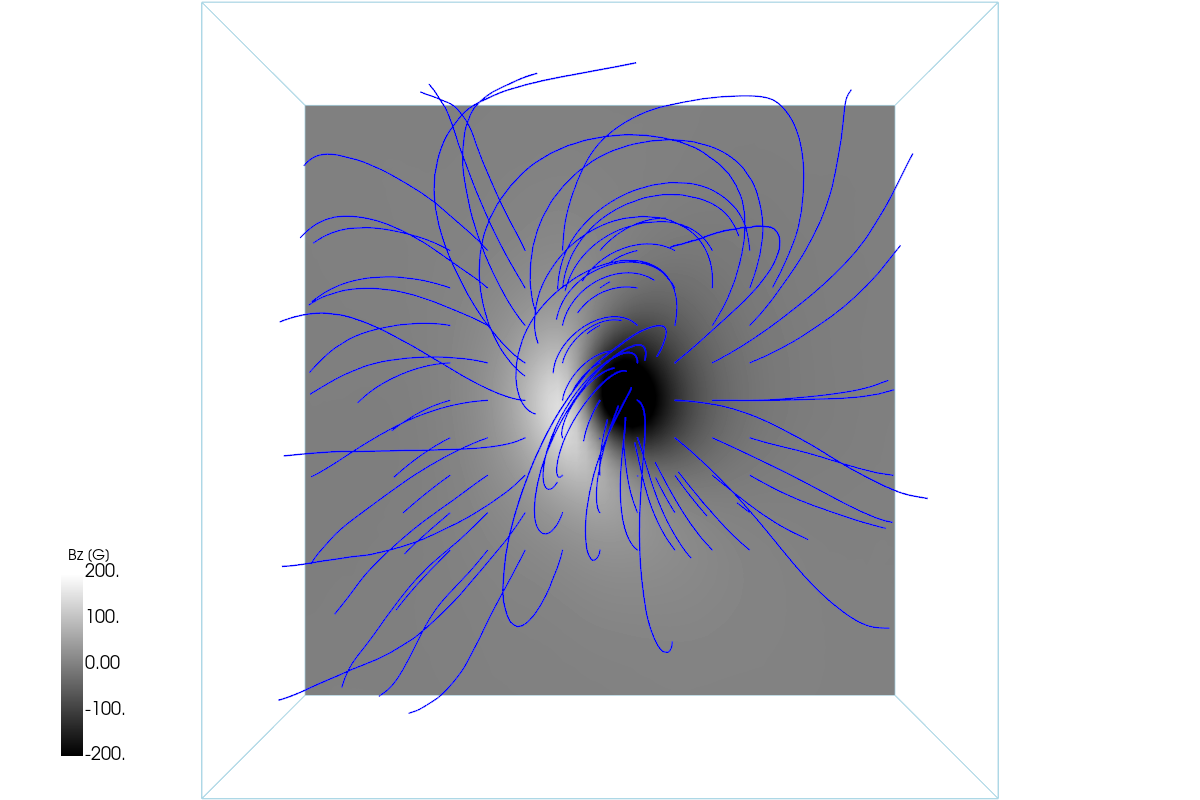

In [13]:
vmin = -200
vmax = 200
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

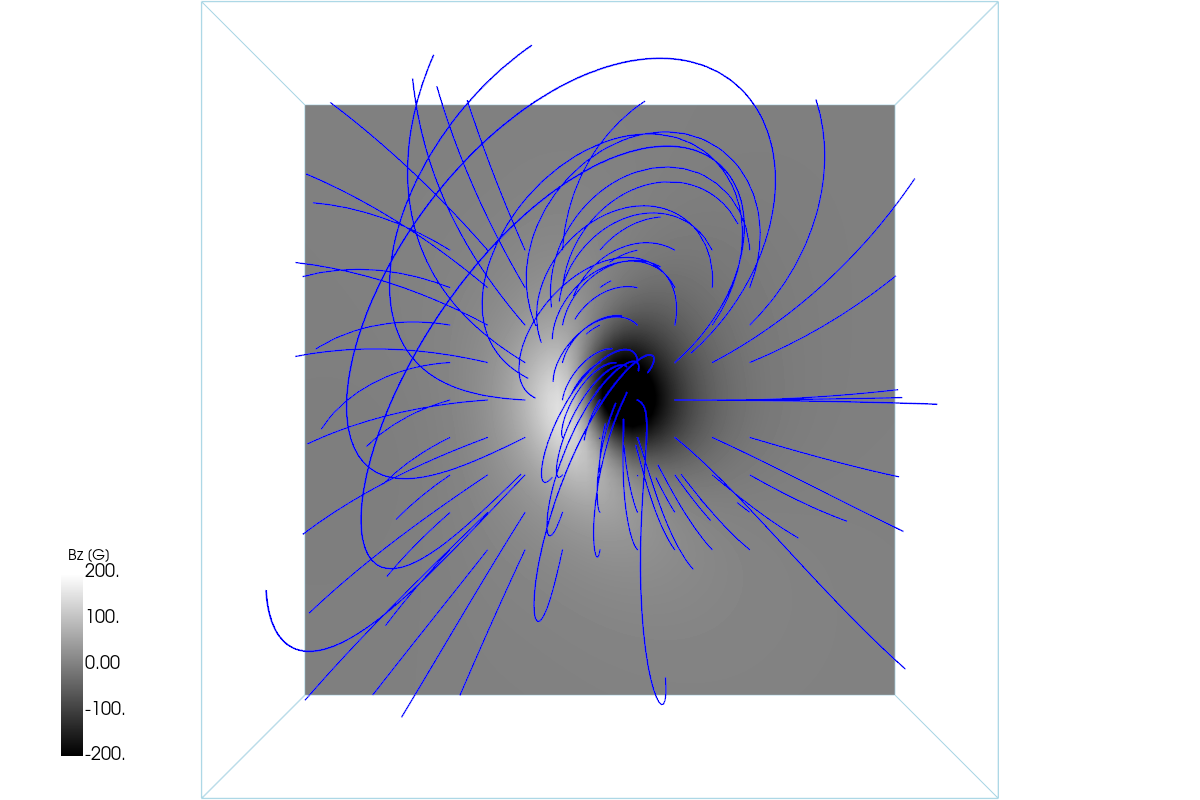

In [14]:
vmin = -200
vmax = 200
i_siz=b_cube.shape[0] / 2
j_siz=b_cube.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b_cube[..., 0]
by = b_cube[..., 1]
bz = b_cube[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()